Using the CMSW framework, and the hypothesis that informed traders use limit orders (Bloomfield, O'Hara, Saar (2003)), we test the thesis that the presence of informed traders leads to a deeper order book.

In [67]:
import numpy as np
import matplotlib.pyplot as plt

from trader import Trader
from order_book import OrderBook

import utilities

from scipy import stats
import statsmodels.api as sm

from tqdm import tqdm


In [68]:
def trader_utility_function(alpha, wealth_mean, wealth_std):
    # utility function: U(W) = - exp(- alpha * W)
    # where W is trader's wealth distributed as N(mu_W, sigma_W):
    return - np.exp(- alpha * wealth_mean + ((alpha * wealth_std)**2)/2)

def compute_wealth_mean_base(trader, payoff_mean):
    # wealth mean value if the trader does nothing = number of shares * payoff mean
    return trader.number_units_stock * payoff_mean

def compute_wealth_std_base(trader, payoff_std):
    # wealth std if the trader does nothing = number of shares * payoff std
    return trader.number_units_stock * payoff_std


def compute_wealth_mean_buy(trader, payoff_mean, price, quantity):
    # wealth mean value if the trader buys = (number of shares + number of shares bought) * payoff mean - (number of shares bought * price paid)
    return (trader.number_units_stock + quantity) * payoff_mean - (price * quantity)

def compute_wealth_std_buy(trader, payoff_std, quantity):
    # wealth std if the trader buys = (number of shares + number of shares bought) * payoff std
    return (trader.number_units_stock + quantity) * payoff_std

def compute_wealth_mean_sell(trader, payoff_mean, price, quantity):
    # wealth mean value if the trader buys = (number of shares - number of shares sold) * payoff mean + (number of shares sold * price)
    return (trader.number_units_stock - quantity) * payoff_mean + (price * quantity)

def compute_wealth_std_sell(trader, payoff_std, quantity):
    # wealth std if the trader buys = (number of shares - number of shares sold) * payoff std
    return (trader.number_units_stock - quantity) * payoff_std

def probability_hit_buy(price, mean, std):
    # we assumed that limit orders have normally distributed prices,
    # so we can find the probability of getting a price inverting the distrib
    z = (price - mean) / std
    
    return stats.norm.cdf(z)


def trader_utility_function_hit(
        trader_base_utility_expectation, 
        trader_limit_utility_expectation, 
        probability_hit_limit_order):
    # utility function for a limit order
    # prob limit order * utility limit order + (1 - prob limit order) * utility do nothing
    return (
        probability_hit_limit_order * trader_limit_utility_expectation
        ) + (1 - probability_hit_limit_order) * trader_base_utility_expectation


In [69]:
np.random.seed(700)


initial_wealth = 5

alpha = 1

ticksize = 0.01

In [70]:
def simulate(book, fraction_of_informed_buyers, prob_seller, simulation_length, payoff_mean, payoff_std):
    # initial bids and asks to provide some liquidity
    # in general the initial conditions of the system are crucial to its future dynamics.
    # in dynamic systems, this is called chaos. I will study the chaos and chaotic systems in further experiments.
    book.bids = [((payoff_mean - ticksize*1), 10), ((payoff_mean - ticksize*2), 12), ((payoff_mean - ticksize*3), 15), ((payoff_mean - ticksize*4), 20)]
    book.asks = [((payoff_mean + ticksize*1), 10), ((payoff_mean + ticksize*2), 12), ((payoff_mean + ticksize*3), 15), ((payoff_mean + ticksize*4), 20)]
    
    for ii in range(simulation_length):
        
        # this quantity is useful to decide if the agent is a buyer or a seller
        rand = np.random.uniform(low=0, high=1)

        # this is the number of shares that will be sold or bought. Notice that this number is between 0 and 1
        # and we provided every seller with 1 share, so there is no short selling
        quantity = abs(np.random.normal(0, 1))

        if rand < prob_seller:
            # the trader is a seller
            # initialise the trader
            trader = Trader(number_units_stock=quantity)

            # get the best bid available. This is useful to make the seller decide its limit sell price
            best_bid = book.bids[0][0]

            # noisy (uninformed) seller -> decides to trade at a random price that is higher than the current best bid
            # why? because he can get the best bid issuing a mkt order
            # round the price to match the tick size
            sell_price = round(best_bid + abs(np.random.normal(0, payoff_std)), utilities.number_of_decimal_digits(ticksize))
            
            # the noisy seller expected payoff is what he thinks the price of the security will be at the end of the day
            # he is selling, so he thinks (THINKS! he doesn't know anything!) that the price will be lower than his sell price
            # lower by a random amount, with payoff_std as std
            expected_payoff = sell_price - abs(np.random.normal(0, payoff_std))

            # compute the seller base utility, that is the utility deriving from not trading
            base_utility = trader_utility_function(
                    alpha=alpha, 
                    wealth_mean=compute_wealth_mean_base(trader, expected_payoff), 
                    wealth_std=compute_wealth_std_base(trader, payoff_std)
                )
            
            # now compute his limit utility, that comes from executing a limit sell at sell_price
            # notice that this is the utility coming from EXECUTING a limit sell. he has no guarantee that this order
            # will actually be executed. We have to compute the prob of execution and then compute the utility coming
            # from issuing a limit order (ISSUING not EXECUTING)
            limit_utility = trader_utility_function(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_sell(trader, expected_payoff, price=sell_price, quantity=quantity), 
                wealth_std=compute_wealth_std_sell(trader, payoff_std, quantity=quantity)
            )

            # now compute his market utility, that comes from issuing a market sell, that will be matched with the best bid.
            # notice that for a mkt order issue = execute
            market_utility = trader_utility_function(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_sell(trader, expected_payoff, price=best_bid, quantity=quantity), 
                wealth_std=compute_wealth_std_sell(trader, payoff_std, quantity=quantity)
            )

            # compute the probability that the limit sell will get executed (this is 1 - the prob that a limit buy with that price would be executed)
            probability_hit_limit_order = 1 - probability_hit_buy(price=sell_price, mean=expected_payoff, std=payoff_std)

            # now we can finally compute the utility given by ISSUING a limit sell
            hit_utility = trader_utility_function_hit(
                trader_base_utility_expectation=base_utility,
                trader_limit_utility_expectation=limit_utility,
                probability_hit_limit_order=probability_hit_limit_order)

            # if the max utility is given by a limit sell, then issue a limit sell
            if (hit_utility > market_utility) and (hit_utility > base_utility):
                trader.submit_order_to_order_book(
                    order_type='limit_sell', 
                    price=sell_price, 
                    quantity=quantity,
                    book=book,
                    verbose=False)
            
            # if the max utility is given by a mkt sell, then issue a mkt sell
            elif (market_utility > base_utility) and (market_utility > hit_utility):
                trader.submit_order_to_order_book(
                    order_type='market_sell', 
                    price=None, 
                    quantity=quantity,
                    book=book,
                    verbose=False)
            
            # else do nothing
            else:
                trader.submit_order_to_order_book(
                    order_type='do_nothing', 
                    price=None, 
                    quantity=None,
                    book=book,
                    verbose=False)

        
        else:
            # the trader is a buyer.
            # generate a random number to know if he is informed or not
            rand = np.random.uniform(low=0, high=1)
            
            # this is the best available ask
            best_ask = book.asks[0][0]

            if rand < fraction_of_informed_buyers:
                # the trader is informed
                # doesn't want to pay more than the final KNOW payoff, so his buy price is either a price lower than the payoff
                # or the best ask, whatever is the lowest.
                buy_price = round(min(payoff_mean - abs(np.random.normal(0, payoff_std)), best_ask), utilities.number_of_decimal_digits(ticksize))

                # his std is zero since he knows the final payoff
                std = 0

                # so his expected payoff is actually the payoff
                expected_payoff = payoff_mean
            else:
                # noise trader, trades around the final payoff.
                # as for the sell case, he wants to buy lower than the best ask
                buy_price = round(best_ask - abs(np.random.normal(0, payoff_std)), utilities.number_of_decimal_digits(ticksize))

                # his std is the payoff_std
                std = payoff_std

                # and his expected payoff is higher than his buy price, since he wants to buy because he believes that the price will rise
                expected_payoff = buy_price + abs(np.random.normal(0, payoff_std))

            # now that we have the necessary quantities, we can compute the utilities
            # issue a trader with 0 units of stocks
            trader = Trader(number_units_stock=0)

            # compute his base utility, that is given by doing nothing
            base_utility = trader_utility_function(
                    alpha=alpha, 
                    wealth_mean=compute_wealth_mean_base(trader, expected_payoff), 
                    wealth_std=compute_wealth_std_base(trader, std)
                )
            
            # compute the utility that comes from the EXECUTION of a limit buy at price = buy_price
            limit_utility = trader_utility_function(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_buy(trader, expected_payoff, price=buy_price, quantity=quantity), 
                wealth_std=compute_wealth_std_buy(trader, std, quantity=quantity)
            )
            
            # compute the utility that comes from the execution of a mkt buy at price = best_ask
            market_utility = trader_utility_function(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_buy(trader, expected_payoff, price=best_ask, quantity=quantity), 
                wealth_std=compute_wealth_std_buy(trader, std, quantity=quantity)
            )

            # compute the prob of a limit buy with price = buy_price to be executed under the mkt conditions
            probability_hit_limit_order = probability_hit_buy(price=buy_price, mean=expected_payoff, std=payoff_std)

            # this is the utility that comes from issuing a limit buy
            hit_utility = trader_utility_function_hit(
                trader_base_utility_expectation=base_utility,
                trader_limit_utility_expectation=limit_utility,
                probability_hit_limit_order=probability_hit_limit_order
                )

            # if the max utility is given by issuing a limit buy, do it
            if (hit_utility > base_utility) and (hit_utility > market_utility):
                trader.submit_order_to_order_book(
                    order_type='limit_buy', 
                    price=buy_price, 
                    quantity=quantity,
                    book=book,
                    verbose=False)
            
            # if it is given by issuing a mkt buy, do it instead
            elif (market_utility > base_utility) and (market_utility > hit_utility):
                trader.submit_order_to_order_book(
                    order_type='market_buy', 
                    price=None,
                    quantity=quantity,
                    book=book,
                    verbose=False)
            
            # else do nothing
            else:
                trader.submit_order_to_order_book(
                    order_type='do_nothing', 
                    price=None, 
                    quantity=None,
                    book=book,
                    verbose=False)


    # return the book object, so we can extract every information
    return book


In [71]:
def multi_sim(simulation_length, s):
    # in this function, we run simulations for different fractions of informed traders
    # given a fixed payoff standard deviation
    depth_inf_0_size = []
    depth_inf_0_volumes = []

    for fraction in tqdm(range(0,101)):
        try:
            f = fraction / 100
            book = simulate(
                            book=OrderBook(), 
                            fraction_of_informed_buyers=f, 
                            prob_seller=0.5, 
                            simulation_length=simulation_length, 
                            payoff_mean=10, 
                            payoff_std=s)

            depth_inf_0_size.append((f, book.depth_sequence_size))
            depth_inf_0_volumes.append((f, book.depth_sequence_volumes))
        except Exception:
            continue
        
    # average sum of volume depends on the fraction of informed traders
    bid_vol = []
    f_list = []
    for d in depth_inf_0_volumes:
        average_depth = np.mean(d[1][int(round(simulation_length*0.8,0)):])
        
        bid_vol.append(average_depth)

        f_list.append(d[0])

    return f_list, bid_vol


In [72]:
f_list_001, bid_vol_001 = multi_sim(simulation_length=1000, s=0.01)

f_list_002, bid_vol_002 = multi_sim(simulation_length=1000, s=0.02)

f_list_005, bid_vol_005 = multi_sim(simulation_length=1000, s=0.05)

f_list_01, bid_vol_01 = multi_sim(simulation_length=1000, s=0.1)

100%|██████████| 101/101 [00:54<00:00,  1.87it/s]


C:\Users\tobi9\AppData\Local\Temp\ipykernel_25616\3458234678.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


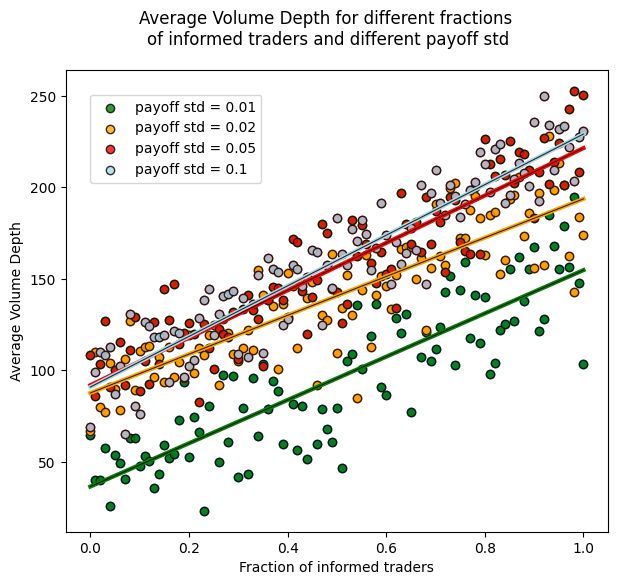

In [73]:
fig, ax = plt.subplots(1,1, figsize=(7,6))

fig.suptitle('Average Volume Depth for different fractions \nof informed traders and different payoff std')

def plot_graph(f_list, bid_vol, s, ax, color_points):
    x = f_list
    y = bid_vol
    x = sm.add_constant(x)

    model = sm.OLS(y, x)
    results = model.fit()

    y_pred = results.predict(x)

    ax.scatter(x[:,1], y)
    ax.set_xlabel('Fraction of informed traders')
    ax.set_ylabel('Average Volume Depth')

    ax.scatter(f_list, bid_vol, label=f'payoff std = {s}', alpha=0.8, edgecolors='black', facecolor=color_points)

    ax.plot(x[:, 1], y_pred, color=color_points, linewidth=3)

    ax.plot(x[:, 1], y_pred, color='black', linewidth=0.8, alpha=0.8)


plot_graph(f_list_001, bid_vol_001, 0.01, ax, 'green')

plot_graph(f_list_002, bid_vol_002, 0.02, ax, 'orange')

plot_graph(f_list_005, bid_vol_005, 0.05, ax, 'red')

plot_graph(f_list_01, bid_vol_01, 0.1, ax, 'lightblue')

fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85))
fig.show()
